## Credit Card Kaggle- Fixing Imbalanced Dataset

### Context
It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

### Content
The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

### Inspiration
Identify fraudulent credit card transactions.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

### Acknowledgements
The dataset has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection. More details on current and past projects on related topics are available on https://www.researchgate.net/project/Fraud-detection-5 and the page of the DefeatFraud project

for more: https://www.youtube.com/watch?v=OJedgzdipC0&ab_channel=KrishNaikKrishNaikVerified

In [1]:
import numpy as np
import pandas as pd
import sklearn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from pylab import rcParams
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42



In [2]:
import os

os.chdir("E:/code/6.MachineLearning/3_Logistic_Regression")

In [4]:
import pandas as pd

df = pd.read_csv("https://raw.githubusercontent.com/pavanpuppala0346/data/main/creditcards.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,3073,1.188739,-0.110925,-0.247423,-0.056450,-0.230669,-0.884735,0.252123,-0.107019,-0.128072,...,-0.339530,-1.248046,0.070858,-0.003754,0.148766,0.706722,-0.132117,-0.008134,58.92,0
2,3073,-0.548584,0.647927,-0.590784,-3.241789,2.647739,2.924031,0.319644,-0.224865,0.765084,...,0.771417,-0.009922,-0.216549,0.995281,0.252971,-0.818252,0.275449,-0.012249,1.00,0
3,3075,-1.516972,-0.798039,-0.352068,-2.878183,3.975981,1.930716,-0.389529,0.566296,0.872467,...,-0.066073,0.103967,-0.592267,1.052167,0.431615,-0.774772,0.268011,-0.124329,1.00,0
4,3075,-2.194168,0.077288,2.313353,1.903733,1.332965,-0.730896,0.126259,-0.315549,-0.171180,...,-0.245901,-0.069742,-0.939594,0.461452,0.454872,-0.050365,-0.364221,-0.175896,29.90,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2493 entries, 0 to 2492
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    2493 non-null   int64  
 1   V1      2493 non-null   float64
 2   V2      2493 non-null   float64
 3   V3      2493 non-null   float64
 4   V4      2493 non-null   float64
 5   V5      2493 non-null   float64
 6   V6      2493 non-null   float64
 7   V7      2493 non-null   float64
 8   V8      2493 non-null   float64
 9   V9      2493 non-null   float64
 10  V10     2493 non-null   float64
 11  V11     2493 non-null   float64
 12  V12     2493 non-null   float64
 13  V13     2493 non-null   float64
 14  V14     2493 non-null   float64
 15  V15     2493 non-null   float64
 16  V16     2493 non-null   float64
 17  V17     2493 non-null   float64
 18  V18     2493 non-null   float64
 19  V19     2493 non-null   float64
 20  V20     2493 non-null   float64
 21  V21     2493 non-null   float64
 22  

In [6]:
columns = df.columns.tolist()     # converting nd array to list
columns = [col for col in columns if col not in ["Class"]]
target = "Class"
X = df[columns]
y = df[target]

print(X.shape)
print(y.shape)

(2493, 30)
(2493,)


## Exploratory Data Analysis

In [7]:
df.isnull().values.any()

False

Text(0, 0.5, 'Frequency')

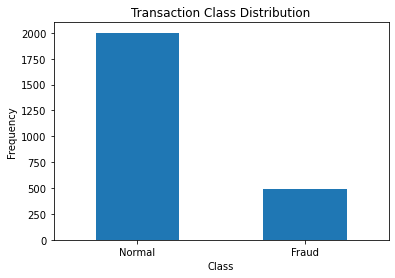

In [8]:
import matplotlib.pyplot as plt

count_classes = pd.value_counts(df['Class'], sort = True)

count_classes.plot(kind = 'bar', rot=0)
LABELS = ["Normal", "Fraud"]

plt.title("Transaction Class Distribution")

plt.xticks(range(2), LABELS)

plt.xlabel("Class")

plt.ylabel("Frequency")

In [9]:
## Get the Fraud and the normal dataset 

fraud = df[df['Class']==1]

normal = df[df['Class']==0]

In [10]:
len(y)

2493

In [11]:
print(fraud.shape)
print(normal.shape)

(492, 31)
(2001, 31)


### Implementing Oversampling for Handling Imbalanced 

In [12]:
from imblearn.under_sampling import NearMiss

In [13]:
from imblearn.combine import SMOTETomek

smk =SMOTETomek(random_state=42)  
X_res,y_res=smk.fit_sample(X,y)

In [14]:
print(X_res.shape)
print(y_res.shape)

(3994, 30)
(3994,)


In [15]:
from collections import Counter

print('Original dataset shape {}'.format(Counter(y)))
print('Resampled dataset shape {}'.format(Counter(y_res)))

Original dataset shape Counter({0: 2001, 1: 492})
Resampled dataset shape Counter({0: 1997, 1: 1997})


### RandomOverSampler to handle imbalanced data

In [16]:
from imblearn.over_sampling import RandomOverSampler

os_model =  RandomOverSampler(random_state=42)
X_train_res, y_train_res = os_model.fit_sample(X,y)

In [17]:
X_train_res.shape,y_train_res.shape

((4002, 30), (4002,))

In [18]:
print('Original dataset shape {}'.format(Counter(y)))
print('Resampled dataset shape {}'.format(Counter(y_train_res)))

Original dataset shape Counter({0: 2001, 1: 492})
Resampled dataset shape Counter({0: 2001, 1: 2001})


In [19]:
# In this example I use SMOTETomek which is a method of imblearn. SMOTETomek is a hybrid method
# which uses an under sampling method (Tomek) in with an over sampling method (SMOTE).
os_us = SMOTETomek(random_state=42)

X_train_res1, y_train_res1 = os_us.fit_sample(X, y)

In [20]:
X_train_res1.shape,y_train_res1.shape

((3994, 30), (3994,))

In [21]:
print('Original dataset shape {}'.format(Counter(y)))
print('Resampled dataset shape {}'.format(Counter(y_train_res1)))

Original dataset shape Counter({0: 2001, 1: 492})
Resampled dataset shape Counter({0: 1997, 1: 1997})
